# Global CO₂ Emissions Analysis
## Notebook 5: Carbon Budget & Required Reductions for High-Income Countries

Calculate how much each country must reduce per capita emissions to stay within the 2°C carbon budget (2024-2050).

**Key questions:**
- What is the maximum sustainable per capita emission level?
- Which countries must reduce, and by how much?
- Is there a correlation between GDP and required reductions?
- Which high-income countries are already within sustainable limits?


## Per capita Carbon Budget

1. Take the remaining 2°C carbon budget: **~1,110 GtCO₂** (2024-2050)
2. Divide by global population over this period
3. Result: **maximum average per capita emissions** that stays within budget
4. Compare each country's 2024 per capita to this limit
5. Calculate required reduction percentage


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df1 =  pd.read_csv("/content/annual-co2-emissions-per-country.csv")
df2 = pd.read_csv("/content/co-emissions-per-capita.csv")
df3 = pd.read_csv("/content/co2-by-source.csv")
df4 = pd.read_csv("/content/population.csv")
df4.columns = ["Entity","Code","Year","Population"]
df = df1.merge(df2,on=["Entity","Code","Year"],how="outer").merge(df3,on=["Entity","Code","Year"],how="outer").merge(df4,on=["Entity","Code","Year"],how="outer")
df_country = df.dropna(subset="Code")
df_country = df_country[~(df_country["Entity"]=="World")]


# Carbon budget remaining for 2°C: 1,110 GtCO₂ (from IPCC AR6, updated to 2025), this gives us the average per-capita level that, if maintained by everyone, would exhaust the budget exactly by 2050.

budget_remaining =  1110e9
start_year = 2024
final_year = 2050
years = final_year - start_year

df_country = df.dropna(subset="Code")
df_country = df_country[~(df_country["Entity"]=="World")]

df_pop_future = df_country[(df_country["Year"]>=start_year) & (df_country["Year"]<= final_year)]
df_pop_future = df_pop_future[["Entity","Code","Year","Population"]]
world_pop_avg = df_pop_future.groupby("Year")["Population"].sum().mean()   # average global population over the period "years"

co2_pc_max_avg = budget_remaining / (years * world_pop_avg)    # max sustainable per capita

For each country:
1. Get 2024 per-capita emissions
2. Calculate excess over sustainable limit
3. Calculate reduction percentage needed

In [ ]:
df_reduction = df_country[df_country["Year"]==2024]
df_reduction  = df_reduction[["Entity","Code","Annual CO₂ emissions (per capita)","Population"]]
df_reduction.columns = ["Entity", "Code", "co2_pc_2024","Population"]
df_reduction = df_reduction.dropna(subset="co2_pc_2024")
df_reduction["reduction"]= df_reduction["co2_pc_2024"] - co2_pc_max_avg
df_reduction["reduction_pct"] = ((df_reduction["reduction"]/df_reduction["co2_pc_2024"])*100).round(2)

df_reduction = df_reduction.sort_values("reduction_pct",ascending=False)

print(f"Reductions calculated for {len(df_reduction)} countries")
print("Top 10 countries requiring largest reductions:")
print(df_reduction[["Entity", "co2_pc_2024", "reduction_pct"]].head(10))
print("10 countries already within budget:")
print(df_reduction[["Entity", "co2_pc_2024", "reduction_pct"]].tail(10))

Reductions calculated for 214 countries
Top 10 countries requiring largest reductions:
                          Entity  co2_pc_2024  reduction_pct
45053                      Qatar    41.271180          88.47
29770                     Kuwait    26.247530          81.87
9190                      Brunei    26.046202          81.73
5539                     Bahrain    24.270082          80.40
53831        Trinidad and Tobago    22.931944          79.25
47574               Saudi Arabia    20.379194          76.65
55919       United Arab Emirates    20.131075          76.36
38619              New Caledonia    18.064400          73.66
48959  Sint Maarten (Dutch part)    16.546274          71.24
42566                       Oman    15.651107          69.60
10 countries already within budget:
                             Entity  co2_pc_2024  reduction_pct
33746                    Madagascar     0.141667       -3258.59
11309                          Chad     0.139484       -3311.16
17355         

We filter for countries with:
- GDP per capita ≥ $20,000 (high-income threshold)
- Population ≥ 5 million (significant emitters)

This focuses on countries with:
- Financial capacity to transition
- Responsibility for historical emissions
- Significant impact on global total

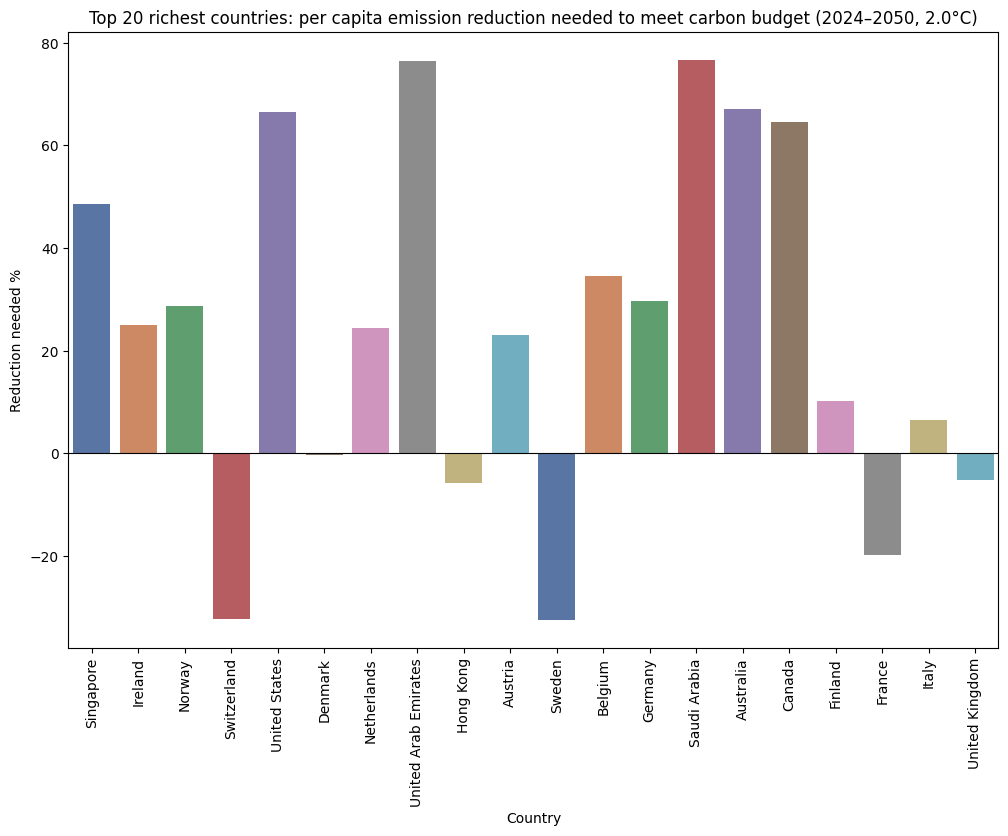

Out of top 20 richest countries:
  14 need to reduce (above sustainable limit)
  6 are already within budget (below limit)


In [ ]:
df_gdp = pd.read_csv("/content/gdp-per-capita-worldbank.csv")
df_gdp.columns = ["Entity", "Code", "Year", "GDP_per_capita","Region"]
df_reduction_gdp = df_reduction.merge(df_gdp[df_gdp["Year"] == 2024][["Entity", "Code", "GDP_per_capita"]],on=["Entity", "Code"],how="left")

threshold_gdp = 20000
threshold_pop = 5000000

df_filtered = df_reduction_gdp[(df_reduction_gdp["GDP_per_capita"]>= threshold_gdp) & (df_reduction_gdp["Population"] >= threshold_pop)]

df_reduction_rich = df_filtered.sort_values("GDP_per_capita",ascending=False).head(20)

palette_abs = sns.color_palette("deep", n_colors=20)
plt.figure(figsize=(12,8))
sns.barplot(x= "Entity", y ="reduction_pct", data = df_reduction_rich, palette=palette_abs, hue = "Entity")
plt.xticks(rotation=90)
plt.ylabel("Reduction needed %")
plt.xlabel("Country")
plt.title("Top 20 richest countries: per capita emission reduction needed to meet carbon budget (2024–2050, 2.0°C)")
plt.axhline(y=0, color='black', linestyle='solid', linewidth=0.8)
plt.show()

above = (df_reduction_rich["reduction_pct"] > 0).sum()
below = (df_reduction_rich["reduction_pct"] <= 0).sum()
print("Out of top 20 richest countries:")
print(f"  {above} need to reduce (above sustainable limit)")
print(f"  {below} are already within budget (below limit)")

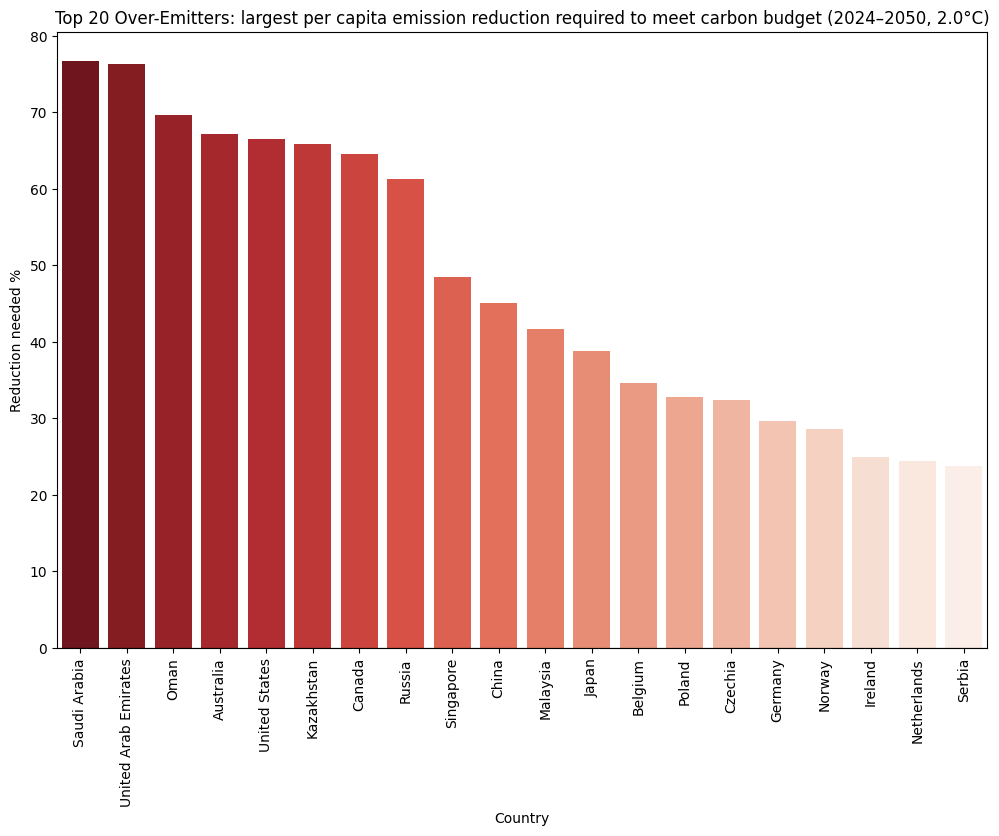

In [ ]:
df_reduction_top = df_filtered.sort_values("reduction_pct",ascending=False).head(20)

palette_abs = sns.color_palette("Reds_r", n_colors=20)
plt.figure(figsize=(12,8))
sns.barplot(x= "Entity", y ="reduction_pct", data = df_reduction_top, palette=palette_abs, hue = "Entity")
plt.xticks(rotation=90)
plt.ylabel("Reduction needed %")
plt.xlabel("Country")
plt.title("Top 20 Over-Emitters: largest per capita emission reduction required to meet carbon budget (2024–2050, 2.0°C)")
plt.axhline(y=0, color='black', linestyle='solid', linewidth=0.8)
plt.show()


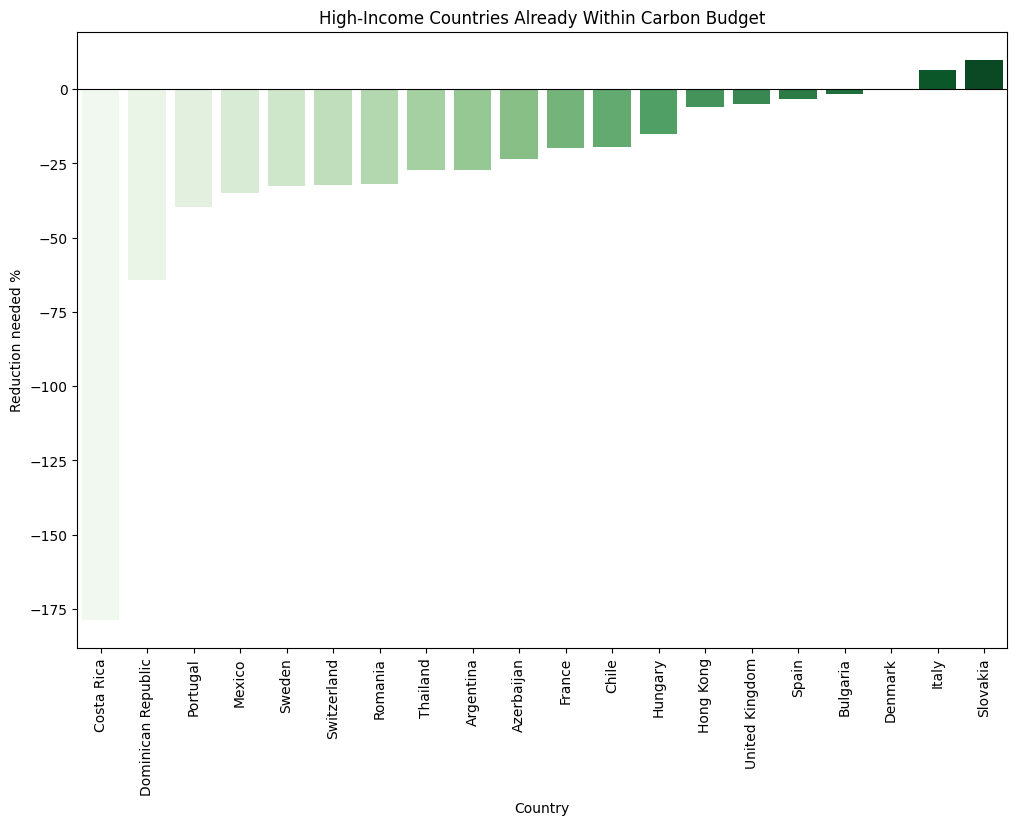

In [ ]:
df_reduction_best = df_filtered.sort_values("reduction_pct").head(20)

palette_abs = sns.color_palette("Greens", n_colors=20)
plt.figure(figsize=(12,8))
sns.barplot(x= "Entity", y ="reduction_pct", data = df_reduction_best, palette=palette_abs, hue = "Entity")
plt.xticks(rotation=90)
plt.ylabel("Reduction needed %")
plt.xlabel("Country")
plt.title("High-Income Countries Already Within Carbon Budget")
plt.axhline(y=0, color='black', linestyle='solid', linewidth=0.8)
plt.show()




Key Findings:

### 1. Methodology:

- Take the 2°C carbon budget: 1,110 GtCO₂ (2024-2050)
- Divide by total global person-years over this period
- Result: ca.4.76 tonnes/person/year as the maximum sustainable average

This is NOT a policy target for any single year, but rather the *average* level that, if maintained globally, would exhaust the budget exactly by 2050.


### 2. Core findings:

#### Global Picture (214 countries):
- **141 countries (66%)** are already below the sustainable limit
- **73 countries (34%)** are above the sustainable limit
Observing the top 10 Over-Emitters (All Countries) table we can see that they are all fossil fuel exporters or small, wealthy territories. Their current lifestyles are 4-9 times the sustainable limit.
The 10 countries with most gap to grow are the world's poorest countries. They have contributed virtually nothing to climate change but still suffer the worst impacts (droughts, floods, heat).

#### High-Income Countries (GDP ≥ $20,000, Pop ≥ 5M):
- **18 countries (38%)** are below the sustainable limit
- **29 countries (62%)** are above the sustainable limit

The majority of the world is already living within carbon limits but the majority of wealthy countries are over-consuming carbon budget.


#### Wealthy economies

Among the top 20 richest countries, 6 are already compliant key factors for success may be the high share of nuclear, hydro electricity, wind power expansion and Coal phaseout.
Out of the 20 richest we observe that 14 must reduce, we can devide them in:
  - **Gulf states**: oil economies with extreme energy use
  - **Anglo settler states (USA, Canada, Australia)**: car culture, sprawl, high consumption
  - **Russia and Kazakhstan**: fossil fuel dependent, inefficient infrastructure

#### Best performers

Among high-income countries, 18 are already within budget. They have in common a Low-carbon electricity (nuclear, hydro, or wind), Excellent public transport (especially rail), Efficient urban design (compact cities, not sprawl) and more of all Long-term policy commitment (carbon pricing, phase-out plans).


### 3. Conclusion:

The 4.76 tonnes/person/year limit shows us:

- Where we are (most rich countries at 2-4 times the limit)
- Where we need to be (everyone converging toward 1-2 t by 2050)
- That it's possible (18 rich countries already there)
